## Dependencies

In [1]:
import json, warnings, shutil
from tweet_utility_scripts import *
from tweet_utility_preprocess_roberta_scripts import *
from transformers import TFRobertaModel, RobertaConfig
from tokenizers import ByteLevelBPETokenizer
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

# Load data

In [2]:
database_base_path = '/kaggle/input/tweet-dataset-split-roberta-base-96/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
display(k_fold.head())

# Unzip files
!tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96/fold_1.tar.gz
# !tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96/fold_2.tar.gz
# !tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96/fold_3.tar.gz
# !tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96/fold_4.tar.gz
# !tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96/fold_5.tar.gz

,textID,text,selected_text,sentiment,text_len,selected_text_len,text_wordCnt,selected_text_wordCnt,fold_1,fold_2,fold_3,fold_4,fold_5
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,35,35,7,7,train,train,train,validation,train
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,45,8,10,2,validation,train,train,train,train
2,088c60f138,my boss is bullying me...,bullying me,negative,25,11,5,2,train,validation,train,train,train
3,9642c003ef,what interview! leave me alone,leave me alone,negative,30,14,5,3,train,validation,train,train,train
4,358bd9e861,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,74,13,14,3,train,train,validation,train,train


fold_1/
fold_1/y_train.npy
fold_1/x_train.npy
fold_1/y_valid.npy
fold_1/x_valid.npy


# Model parameters

In [3]:
vocab_path = database_base_path + 'vocab.json'
merges_path = database_base_path + 'merges.txt'
base_path = '/kaggle/input/qa-transformers/roberta/'

config = {
  "MAX_LEN": 96,
  "BATCH_SIZE": 32,
  "EPOCHS": 5,
  "LEARNING_RATE": 3e-5,
  "ES_PATIENCE": 1,
  "question_size": 4,
  "N_FOLDS": 1,
  "base_model_path": base_path + 'roberta-base-tf_model.h5',
  "config_path": base_path + 'roberta-base-config.json'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

# Model

In [4]:
module_config = RobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFRobertaModel.from_pretrained(config['base_model_path'], config=module_config, name="base_model")
    sequence_output = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    last_state = sequence_output[0]
    
    x_start = layers.Dropout(0.1)(last_state) 
    x_start = layers.Conv1D(1, 1)(x_start)
    x_start = layers.Flatten()(x_start)
    y_start = layers.Activation('softmax', name='y_start')(x_start)

    x_end = layers.Dropout(0.1)(last_state) 
    x_end = layers.Conv1D(1, 1)(x_end)
    x_end = layers.Flatten()(x_end)
    y_end = layers.Activation('softmax', name='y_end')(x_end)
    
    model = Model(inputs=[input_ids, attention_mask], outputs=[y_start, y_end])
    model.compile(optimizers.Adam(lr=config['LEARNING_RATE']), 
                  loss=losses.SparseCategoricalCrossentropy(), 
                  metrics=[metrics.SparseCategoricalAccuracy()])
    
    return model

# Tokenizer

In [5]:
tokenizer = ByteLevelBPETokenizer(vocab_file=vocab_path, merges_file=merges_path, lowercase=True, add_prefix_space=True)
tokenizer.save('./')

['./vocab.json', './merges.txt']

# Train

In [6]:
history_list = []
AUTO = tf.data.experimental.AUTOTUNE

for n_fold in range(config['N_FOLDS']):
    n_fold +=1
    print('\nFOLD: %d' % (n_fold))
    # Load data
    base_data_path = 'fold_%d/' % (n_fold)
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train.npy').argmax(-1)
    x_valid = np.load(base_data_path + 'x_valid.npy')
    y_valid = np.load(base_data_path + 'y_valid.npy').argmax(-1)
    
    ### Delete data dir
    shutil.rmtree(base_data_path)

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold)
    model = model_fn(config['MAX_LEN'])
    es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                       restore_best_weights=True, verbose=1)
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', 
                                 save_best_only=True, save_weights_only=True)

    history = model.fit(list(x_train), list(y_train),
                    validation_data=(list(x_valid), list(y_valid)),
                    batch_size=config['BATCH_SIZE'], 
                    callbacks=[checkpoint, es],
                    epochs=config['EPOCHS'], 
                    verbose=1).history
    history_list.append(history)
    
    # Make predictions
    train_preds = model.predict(list(x_train))
    valid_preds = model.predict(list(x_valid))
    
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'train', 'start_fold_%d' % (n_fold)] = train_preds[0].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'train', 'end_fold_%d' % (n_fold)] = train_preds[1].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'validation', 'start_fold_%d' % (n_fold)] = valid_preds[0].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'validation', 'end_fold_%d' % (n_fold)] = valid_preds[1].argmax(axis=-1)
    
    k_fold['end_fold_%d' % (n_fold)] = k_fold['end_fold_%d' % (n_fold)].astype(int)
    k_fold['start_fold_%d' % (n_fold)] = k_fold['start_fold_%d' % (n_fold)].astype(int)
    k_fold['end_fold_%d' % (n_fold)].clip(0, k_fold['text_len'], inplace=True)
    k_fold['start_fold_%d' % (n_fold)].clip(0, k_fold['end_fold_%d' % (n_fold)], inplace=True)
    k_fold['prediction_fold_%d' % (n_fold)] = k_fold.apply(lambda x: decode(x['start_fold_%d' % (n_fold)], x['end_fold_%d' % (n_fold)], x['text'], config['question_size'], tokenizer), axis=1)
    k_fold['prediction_fold_%d' % (n_fold)].fillna('', inplace=True)
    k_fold['jaccard_fold_%d' % (n_fold)] = k_fold.apply(lambda x: jaccard(x['text'], x['prediction_fold_%d' % (n_fold)]), axis=1)


FOLD: 1
Train on 21984 samples, validate on 5496 samples
Epoch 1/5
21984/21984 [==============================] - 291s 13ms/sample - loss: 2.1529 - y_start_loss: 1.0781 - y_end_loss: 1.0748 - y_start_sparse_categorical_accuracy: 0.6476 - y_end_sparse_categorical_accuracy: 0.6576 - val_loss: 1.6342 - val_y_start_loss: 0.8477 - val_y_end_loss: 0.7859 - val_y_start_sparse_categorical_accuracy: 0.7098 - val_y_end_sparse_categorical_accuracy: 0.7254
Epoch 2/5
21984/21984 [==============================] - 274s 12ms/sample - loss: 1.6109 - y_start_loss: 0.8345 - y_end_loss: 0.7764 - y_start_sparse_categorical_accuracy: 0.7019 - y_end_sparse_categorical_accuracy: 0.7255 - val_loss: 1.5534 - val_y_start_loss: 0.7986 - val_y_end_loss: 0.7543 - val_y_start_sparse_categorical_accuracy: 0.7102 - val_y_end_sparse_categorical_accuracy: 0.7267
Epoch 3/5
21984/21984 [==============================] - 271s 12ms/sample - loss: 1.4384 - y_start_loss: 0.7500 - y_end_loss: 0.6885 - y_start_sparse_categori

# Model loss graph

Fold: 1


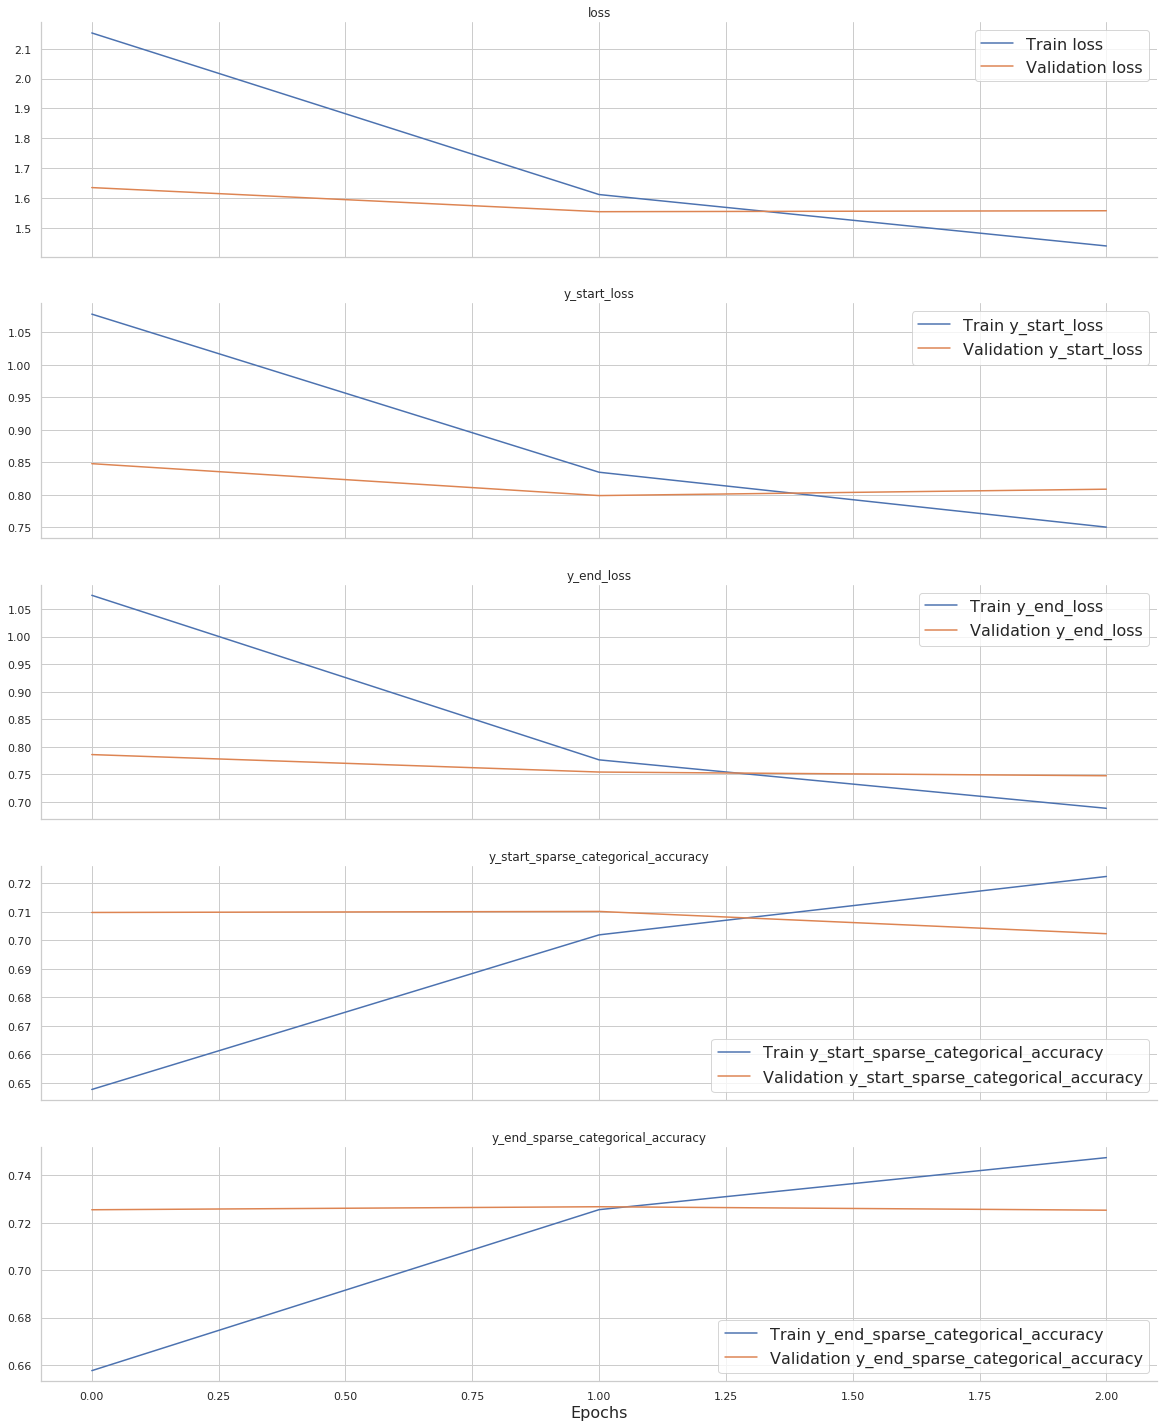

In [7]:
sns.set(style="whitegrid")
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history_list[n_fold])

# Model evaluation

In [8]:
display(evaluate_model_kfold(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1
Metric/Jaccard,,,,,
Overall,0.73438,0.704676,0.0297047,0.73438,0.704676
Sentiment neutral,0.974202,0.97391,0.000292262,0.974202,0.97391
Sentiment negative,0.576946,0.518401,0.0585457,0.576946,0.518401
Sentiment positive,0.566494,0.524645,0.0418493,0.566494,0.524645
0 <= text wordCnt < 3,0.858683,0.813433,0.0452501,0.858683,0.813433
3 <= text wordCnt < 10,0.791833,0.75674,0.0350927,0.791833,0.75674
10 <= text wordCnt < 30,0.70006,0.671747,0.0283123,0.70006,0.671747
30 <= text wordCnt < 100,0.623708,0.702859,-0.0791507,0.623708,0.702859
0 <= selected text wordCnt < 3,0.677019,0.619075,0.0579439,0.677019,0.619075


# Visualize predictions

In [9]:
display(k_fold[[c for c in k_fold.columns if not (c.startswith('textID') or 
                                                  c.startswith('text_len') or 
                                                  c.startswith('selected_text_len') or 
                                                  c.startswith('text_wordCnt') or 
                                                  c.startswith('selected_text_wordCnt') or 
                                                  c.startswith('fold_') or 
                                                  c.startswith('start_fold_') or 
                                                  c.startswith('end_fold_'))]].head(15))

,text,selected_text,sentiment,prediction_fold_1,jaccard_fold_1
0,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,"i`d have responded, if i were going",1.000000
1,sooo sad i will miss you here in san diego!!!,sooo sad,negative,sooo sad,0.200000
2,my boss is bullying me...,bullying me,negative,bullying me...,0.400000
3,what interview! leave me alone,leave me alone,negative,leave me alone,0.600000
4,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,"sons of ****,",0.214286
5,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,some shameless plugging for the best rangers f...,0.833333
6,2am feedings for the baby are fun when he is a...,fun,positive,fun,0.071429
7,soooo high,soooo high,neutral,soooo high,1.000000
8,both of you,both of you,neutral,both of you,1.000000
9,journey!? wow... u just became cooler. hehe.....,wow... u just became cooler.,positive,wow...,0.100000
